# Recommender Systems 2023/24 Challenge

@authors Federico Sarrocco, Alessandro Vacca

### Load the data:

In [1]:
import pandas as pd
URM_path = "data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [2]:
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


### BUILD the SPARSE URM matrix

In [3]:
import scipy.sparse as sps
import numpy as np

mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,0,8,1
9,0,9,1


In [4]:
n_users = len(URM_all_dataframe["UserID"].unique())
n_items = len(URM_all_dataframe["ItemID"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<12638x22222 sparse matrix of type '<class 'numpy.int64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Let's take a look at the URM


In [5]:
URM_all = sps.csr_matrix(URM_all)
items_per_user = np.ediff1d(URM_all.indptr)

URM_all = sps.csc_matrix(URM_all)
users_per_item = np.ediff1d(URM_all.indptr)

URM_all = sps.csr_matrix(URM_all)

In [6]:
print(items_per_user.shape)
print(users_per_item.shape)

(12638,)
(22222,)


In [7]:
items_per_user = np.sort(items_per_user)
users_per_item = np.sort(users_per_item)

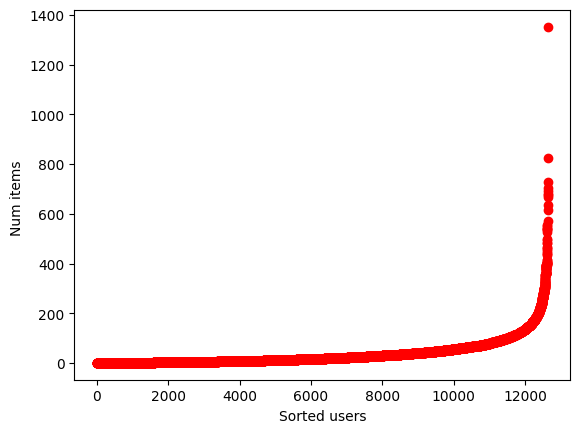

In [8]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(items_per_user, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted users')
pyplot.show()

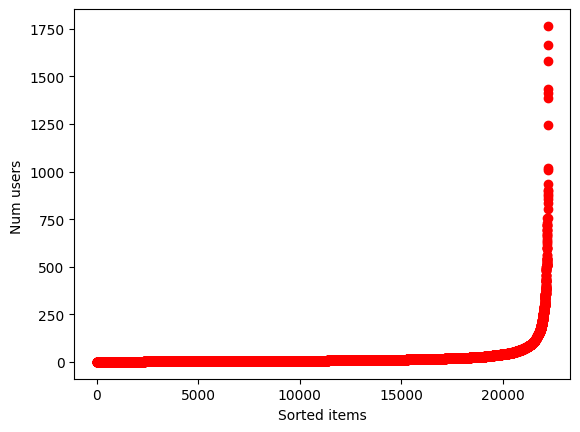

In [9]:
pyplot.plot(users_per_item, 'ro')
pyplot.ylabel('Num users ')
pyplot.xlabel('Sorted items')
pyplot.show()

## DATASET SPLIT

In [10]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2569 (20.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2132 (16.9%) Users that have less than 1 test interactions


## Similarity matrix

In [11]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train, shrink=100.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 22222 (100.0%), 4430.44 column/sec. Elapsed time 5.02 sec


<22222x22222 sparse matrix of type '<class 'numpy.float32'>'
	with 2107925 stored elements in Compressed Sparse Row format>

### Prediction for a certain user

In [12]:
user_id = 80

user_profile = URM_train[user_id]
scores = user_profile.dot(W_sparse).toarray().ravel()

ranking = scores.argsort()[::-1]

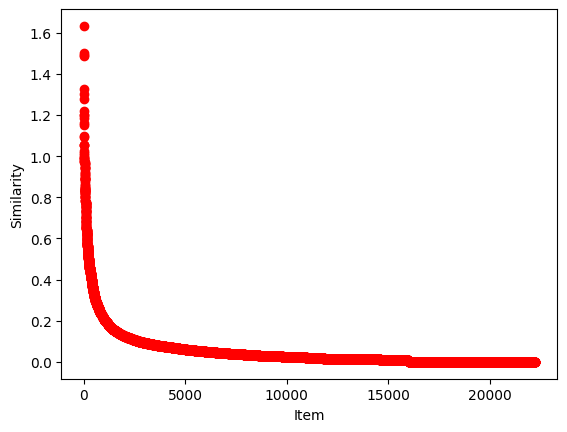

array([ 189, 1266,  517,   44,   47,  291,  809,  808,  811,  284])

In [13]:
pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()
ranking[0:10]

### All together inside a class

In [31]:
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.NonPersonalizedRecommender import TopPop

earlystopping_keywargs = {"validation_every_n": 5,
                              "stop_on_validation": True,
                              "evaluator_object": EvaluatorHoldout(URM_validation, [20], exclude_seen=True),
                              "lower_validations_allowed": 5,
                              "validation_metric": "MAP",
                              }

recommender = IALSRecommender(URM_train)
recommender.fit(epochs = 40,**earlystopping_keywargs)

top_recommender = TopPop(URM_train)
top_recommender.fit()

EvaluatorHoldout: Ignoring 2582 (20.4%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 516 ( 4.1%) users with no interactions.
IALSRecommender: URM Detected 330 ( 1.5%) items with no interactions.
IALSRecommender: Epoch 1 of 40. Elapsed time 3.57 sec
IALSRecommender: Epoch 2 of 40. Elapsed time 7.32 sec
IALSRecommender: Epoch 3 of 40. Elapsed time 10.41 sec
IALSRecommender: Epoch 4 of 40. Elapsed time 13.68 sec
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 10056 (100.0%) in 4.13 sec. Users per second: 2434
IALSRecommender: CUTOFF: 20 - PRECISION: 0.0320903, PRECISION_RECALL_MIN_DEN: 0.1126683, RECALL: 0.1102779, MAP: 0.0102534, MAP_MIN_DEN: 0.0360808, MRR: 0.1360366, NDCG: 0.0791024, F1: 0.0497141, HIT_RATE: 0.4066229, ARHR_ALL_HITS: 0.1652154, NOVELTY: 0.0087883, AVERAGE_POPULARITY: 0.3575472, DIVERSITY_MEAN_INTER_LIST: 0.8495581, DIVERSITY_HERFINDAHL: 0.9924737, COVERAGE_ITEM: 0.0220052, COVERAGE_ITEM_HIT: 0.0153002, ITEMS_IN_GT: 0.743

In [15]:
evaluator_test.evaluateRecommender(top_recommender)

EvaluatorHoldout: Processed 10465 (100.0%) in 3.22 sec. Users per second: 3252


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.027998                 0.052572  0.045015  0.010933    0.019688   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.088208  0.043098  0.034524  0.226947      0.098002  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.828058          0.187925    0.828058       0.000536   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10            3.601492                   0.913182              0.00156   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [16]:
evaluator_test.evaluateRecommender(recommender)

EvaluatorHoldout: Processed 10465 (100.0%) in 4.68 sec. Users per second: 2235


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.053636                 0.096234  0.081943  0.023996    0.043109   
 
             MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                       ...   
 10      0.16593  0.084868  0.064834  0.368275      0.198611  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.828058          0.304953    0.828058        0.00474   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10            7.133695                   0.990246             0.013799   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                      

## Hyperparameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Optimize the recommendation quality on the validation data, then use those hyperparameters to train the model in all the data you have (train + validation) and evaluate on the test data

PureSVDRecommender: URM Detected 458 ( 3.6%) users with no interactions.
PureSVDRecommender: URM Detected 332 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.38 sec
EvaluatorHoldout: Processed 9986 (100.0%) in 4.84 sec. Users per second: 2063
PureSVDRecommender: URM Detected 458 ( 3.6%) users with no interactions.
PureSVDRecommender: URM Detected 332 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.59 sec
EvaluatorHoldout: Processed 9986 (100.0%) in 4.83 sec. Users per second: 2069
PureSVDRecommender: URM Detected 458 ( 3.6%) users with no interactions.
PureSVDRecommender: URM Detected 332 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.83 sec
EvaluatorHoldout: Processed 9986 (100.0%) in 5.28

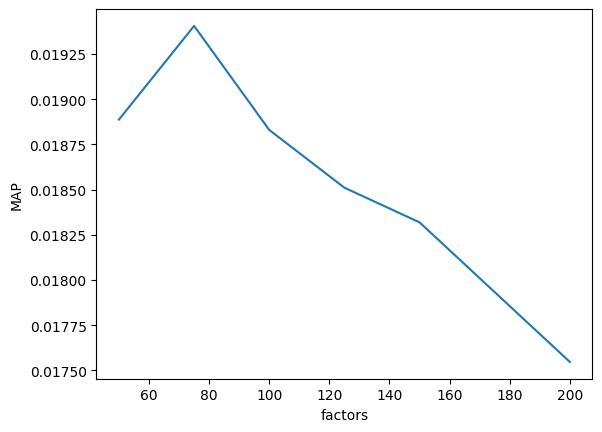

In [29]:
x_tick = [50, 75, 100, 125, 150, 200]
MAP_per_factors = []

for factor in x_tick:
    
    recommender = IALSRecommender(URM_train)
    recommender.fit()
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_factors.append(result_df.loc[10]["MAP"])

pyplot.plot(x_tick, MAP_per_factors)
pyplot.ylabel('MAP')
pyplot.xlabel('factors')
pyplot.show()

# Generate submissions

In [ ]:
# RETRAIN WITH FULL DATASET
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

earlystopping_keywargs = {"validation_every_n": 5,
                              "stop_on_validation": True,
                              "evaluator_object": EvaluatorHoldout(URM_validation, [10], exclude_seen=True),
                              "lower_validations_allowed": 5,
                              "validation_metric": "MAP",
                              }

recommender = IALSRecommender(URM_all)
recommender.fit(epochs=300)

top_recommender = TopPop(URM_all)
top_recommender.fit()

EvaluatorHoldout: Ignoring 2569 (20.3%) Users that have less than 1 test interactions
IALSRecommender: Epoch 1 of 300. Elapsed time 22.74 sec
IALSRecommender: Epoch 2 of 300. Elapsed time 31.10 sec
IALSRecommender: Epoch 3 of 300. Elapsed time 38.95 sec
IALSRecommender: Epoch 4 of 300. Elapsed time 46.26 sec
IALSRecommender: Epoch 5 of 300. Elapsed time 54.18 sec
IALSRecommender: Epoch 6 of 300. Elapsed time 1.02 min
IALSRecommender: Epoch 7 of 300. Elapsed time 1.20 min
IALSRecommender: Epoch 8 of 300. Elapsed time 1.45 min
IALSRecommender: Epoch 9 of 300. Elapsed time 1.60 min
IALSRecommender: Epoch 10 of 300. Elapsed time 1.76 min
IALSRecommender: Epoch 11 of 300. Elapsed time 1.88 min
IALSRecommender: Epoch 12 of 300. Elapsed time 2.00 min
IALSRecommender: Epoch 13 of 300. Elapsed time 2.27 min
IALSRecommender: Epoch 14 of 300. Elapsed time 2.49 min
IALSRecommender: Epoch 15 of 300. Elapsed time 2.68 min
IALSRecommender: Epoch 16 of 300. Elapsed time 2.92 min
IALSRecommender: Epoch

In [31]:
top_recommender.recommend(np.array([22,2,5]), cutoff=10)

[[517, 189, 44, 0, 284, 808, 285, 557, 1, 1266],
 [517, 189, 44, 0, 284, 808, 285, 557, 1, 1266],
 [517, 0, 284, 808, 285, 557, 1, 1266, 1265, 841]]

In [32]:
import pandas as pd
URM_path = "data_target_users_test.csv"
URM_all_submission_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int},
                                engine='python')

URM_all_submission_dataframe.columns = ["UserID"]

In [33]:
URM_all_submission_dataframe["UserIDMapped"] = URM_all_submission_dataframe["UserID"].map(user_original_ID_to_index)

In [34]:
import pandas as pd
# Assuming you have a DataFrame URM_all_submission_dataframe with 'UserIDMapped' and 'item_list' columns

# First, create a mask for non-null 'UserIDMapped' values
mask = ~URM_all_submission_dataframe['UserIDMapped'].isna()
URM_all_submission_dataframe['item_list'] = top_recommender.recommend(URM_all_submission_dataframe['UserIDMapped'], cutoff=10, remove_seen_flag=False)
URM_all_submission_dataframe.loc[mask, 'item_list'] = pd.Series(recommender.recommend(URM_all_submission_dataframe.loc[mask, 'UserIDMapped'].to_numpy().astype(int), cutoff=10, remove_seen_flag=True), index=URM_all_submission_dataframe.index[mask])

In [35]:
item_index_to_original_id = item_original_ID_to_index.reset_index().set_index(0).to_numpy().reshape(-1)
URM_all_submission_dataframe['item_list'] = URM_all_submission_dataframe['item_list'].apply(lambda item_indices: [item_index_to_original_id[index] for index in item_indices])

In [36]:
submission = URM_all_submission_dataframe[["UserID","item_list"]]
submission.columns = ["user_id", "item_list"]
submission['item_list'] = submission['item_list'].apply(lambda x: ' '.join(map(str, x))) # remove brakets

# Convert item_list to string format
submission['item_list'] = submission['item_list'].astype(str)

# Save to CSV without quotes and with the desired format
# submission.to_csv("submission.csv", index=False, header=["user_id", "item_list"], quoting=csv.QUOTE_NONE, sep=',')
def write_csv_without_quotes(df, file_path):
    with open(file_path, 'w', newline='') as f:
        f.write("user_id,item_list\n")
        for index, row in df.iterrows():
            f.write(f"{row['user_id']},{row['item_list']}\n")

# Save the DataFrame to CSV without quotes and with the desired format
write_csv_without_quotes(submission, "submission.csv")

/var/folders/l3/n3yjvx_d2g9dy0ztkyft2th40000gn/T/ipykernel_50253/2149847291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['item_list'] = submission['item_list'].apply(lambda x: ' '.join(map(str, x))) # remove brakets
/var/folders/l3/n3yjvx_d2g9dy0ztkyft2th40000gn/T/ipykernel_50253/2149847291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['item_list'] = submission['item_list'].astype(str)


In [37]:
submission['item_list']

0           36 101 52 102 112 139 403 146 318 156
1                50 47 12 28 46 114 125 136 5 131
2           59 259 414 536 584 648 117 18 159 956
3                28 50 59 145 97 54 136 90 249 46
4            116 77 164 62 131 179 175 148 186 95
                           ...                   
10877      161 155 108 337 105 87 506 403 303 345
10878      13 133 24 57 593 474 6179 6720 350 579
10879    119 147 83 299 540 133 809 625 1446 1411
10880           23 32 129 89 82 96 242 282 313 37
10881      347 292 329 139 353 408 415 24 733 132
Name: item_list, Length: 10882, dtype: object